In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [3]:
#Reading the Data  you might chane the path for the relevant one 
data = pd.read_csv('drive/My Drive/data.csv')

In [4]:
# Changing to datetime index
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime',inplace=True)



In [5]:
# Data Exploration
print (data.shape)
print (data.dtypes)

(10886, 11)
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


In [6]:
#Creating features 
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month
data['year'] = data.index.year
data['day'] = data.index.day
data['week'] = data.index.week
# data['monthday'] = data.index.daysinmonth

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [7]:
data['season'] = data['season'].astype('category')

In [8]:
#Imputing the missing values of the windspeed 


data_without_wind = data[data["windspeed"]==0]
data_with_wind= data[data["windspeed"]!=0]
rf_wind = RandomForestRegressor()
wind_predictors = ["season","weather","humidity","temp","atemp","month",'month','week',]
rf_wind.fit(data_with_wind[wind_predictors], data_with_wind["windspeed"])

new_wind = rf_wind.predict(data_without_wind[wind_predictors])
data_without_wind["windspeed"] = new_wind
data = data_with_wind.append(data_without_wind)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


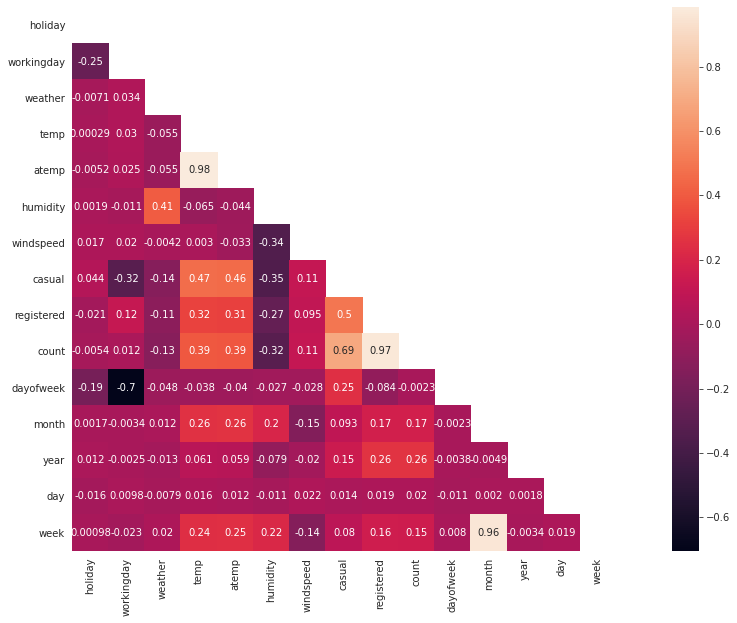

In [9]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 10))
    ax = sns.heatmap(corr, mask=mask, square=True,annot=True)

#Since we see almost perfect correlation between atemp and temp we drop one of the them to avoid multicolinearity
data.drop(['atemp'],axis=1,inplace=True)

In [10]:

#Turning data into daily data preserving the important measures for the relevant variables
daily_data = data.resample('D').agg({'casual':'sum',
                        'registered':'sum',
                        'count':'sum',
                         'temp':['mean','var','max','min'],         
                        'humidity':['mean','var','max','min'],
                        'windspeed':['mean','var','max','min'],
                        'weather':['min','max','mean']
                        })
daily_data

casual registered count       temp  ... windspeed weather               
              sum        sum   sum       mean  ...       min     min  max      mean
datetime                                       ...                                 
2011-01-01    331        654   985  14.110833  ...  6.003200     1.0  3.0  1.583333
2011-01-02    131        670   801  14.902609  ...  8.998100     1.0  3.0  1.956522
2011-01-03    120       1229  1349   8.050909  ...  6.729463     1.0  1.0  1.000000
2011-01-04    108       1454  1562   8.200000  ...  6.003200     1.0  2.0  1.043478
2011-01-05     82       1518  1600   9.305217  ...  6.003200     1.0  1.0  1.000000
...           ...        ...   ...        ...  ...       ...     ...  ...       ...
2012-12-15    767       4280  5047  13.290833  ...  6.003200     1.0  2.0  1.375000
2012-12-16    538       3248  3786  14.862500  ...  6.003200     1.0  3.0  2.041667
2012-12-17    212       4373  4585  16.126667  ...  6.003200     2.0  3.0  2.125000
2012-12-18    433       5124  5557  16.844167  ...  6.003200     1.0  3.0  1.208333
2012-12-19    333       4934  5267  13.632500  ...  6.003200     1.0  1.0  1.000000

[719 rows x 18 columns]

In [11]:

#Rearranging columns names
daily_data.columns  = [col[0]+"_"+col[1]  if isinstance(col,tuple) else col for col in daily_data.columns  ]



In [12]:
#Data that will be known from the beginning 
known_daily_data = data[['season', 'holiday', 'workingday','dayofweek', 'month','day'
       ,'week', 'year']].resample('D').first()
daily_data = daily_data.merge(known_daily_data,right_index=True,left_index=True)


In [13]:
#Replcaing values for missing dates
daily_data[['count_sum','registered_sum','casual_sum']] = daily_data[['count_sum','registered_sum','casual_sum']].replace(0,np.nan)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


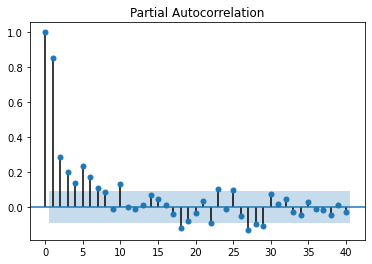

In [14]:
# Partial Auto-Correlation plot in order to determine the lagged effect of variables
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(daily_data['count_sum'].dropna(), lags=40)
plt.show()

#Unneccsarry features 
# diff_one = daily_data.diff().shift(1).add_suffix('diff_one')
# diff_two = daily_data.diff(2).shift(1).add_suffix('diff_two')
# diff_three = daily_data.diff(3).shift(1).add_suffix('diff_three')

# last_one = daily_data.shift(1).add_suffix('last_one')
# last_two = daily_data.shift(2).add_suffix('last_two')
# last_three = daily_data.shift(3).add_suffix('last_three')

# comp_data = diff_one.merge(diff_two,right_index=True,left_index=True)
# comp_data = comp_data.merge(diff_three,right_index=True,left_index=True)
# comp_data = comp_data.merge(last_one,right_index=True,left_index=True)
# comp_data = comp_data.merge(last_two,right_index=True,left_index=True)
# comp_data = comp_data.merge(last_three,right_index=True,left_index=True)
# comp_data = comp_data.dropna()
# comp_data = comp_data.merge(known_daily_data,right_index=True,left_index=True)
# comp_data = comp_data.merge(known_daily_data.shift(1).add_suffix('last_one'),right_index=True,left_index=True)

# comp_data['y'] = reg_sum.loc[comp_data.index]
# comp_data = comp_data.dropna()
# train = comp_data[:int(len(comp_data)*0.8)]
# test = comp_data[int(len(comp_data)*0.8):]
 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4132493470>,
      dtype=object)

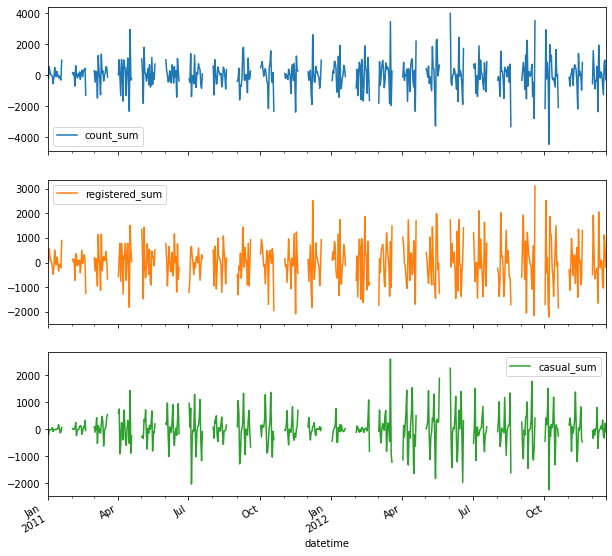

In [15]:
daily_data[['count_sum','registered_sum','casual_sum']].diff().plot(subplots=True,sharex=True,figsize=(10,10))
# We should predict the diffrenciated values instead of the original. 
# than we moved from count data to regular regression problem 


In [16]:
columns_for_shifts=  ['temp_mean',
 'temp_var',
 'temp_max',
 'temp_min',
 'humidity_mean',
 'humidity_var',
 'humidity_max',
 'humidity_min',
 'windspeed_mean',
 'windspeed_var',
 'windspeed_max',
 'windspeed_min',
 'weather_min',
 'weather_max',
 'weather_mean']
daily_data[columns_for_shifts] = daily_data[columns_for_shifts].shift(1)

In [17]:
#Appending the last day features
daily_data = daily_data.merge(daily_data[['count_sum','registered_sum','casual_sum']].shift(1).add_suffix('_last_day'),left_index=True,right_index=True)

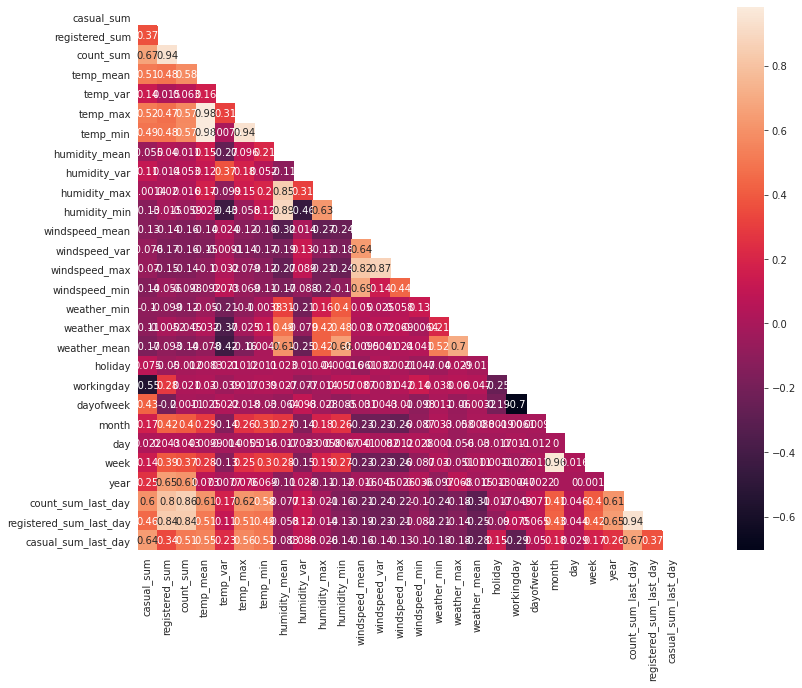

In [18]:
corr = daily_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 10))
    ax = sns.heatmap(corr, mask=mask, square=True,annot=True)

In [19]:
def rolling(data,col,num=2):
  data['rolling_mean_{}_{}'.format(col,num)] = data[col].rolling('{}D'.format(num),closed='left').mean()
  data['rolling_std_{}_{}'.format(col,num)] = data[col].rolling('{}D'.format(num),closed='left').std()
  # data['outlier_{}'.format(col)] = np.where(data[col]-data['rolling_mean_{}'.format(col)]>=3*data['rolling_std_{}'.format(col)],1,0)
  data.drop(['rolling_std_{}_{}'.format(col,num)],axis=1,inplace=True)
  return data

for col in ['registered_sum','casual_sum']:
  daily_data = rolling(daily_data,col)


In [20]:
season = pd.get_dummies(daily_data['season'])
season.columns = ['Spring','Summer','Fall','Winter']
daily_data = daily_data.drop('season',axis=1).merge(season,right_index=True,left_index=True)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  1.2min finished


-0.31770936202438205
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 300, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


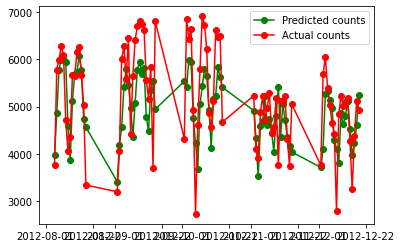

<Figure size 432x288 with 0 Axes>

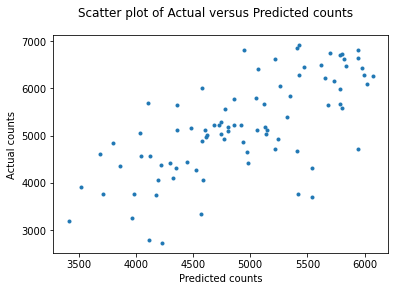

rmse: 783.4117949240463
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  1.2min finished


0.6532029504635084
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 300, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


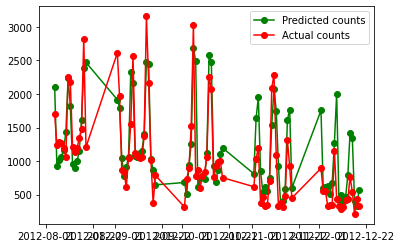

<Figure size 432x288 with 0 Axes>

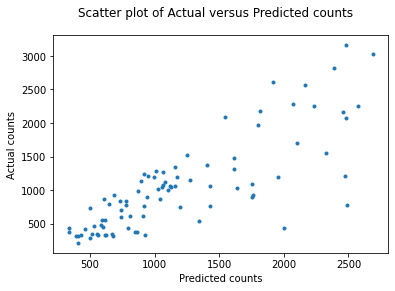

rmse: 441.27399068425683


In [21]:
#Somehow I couldn't use the XGBregressor with poisson objective so I insert the regular prediction into the poisson regression


reg_features = daily_data.drop(['casual_sum','count_sum'],axis=1)
reg_features = reg_features.dropna()

cas_features = daily_data.drop(['registered_sum','count_sum'],axis=1)
cas_features = cas_features.dropna()

for data,target in [(reg_features,'registered_sum'),(cas_features,'casual_sum')]:
  x_train,x_test,y_train,y_test = train_test_split(data.drop(target,axis=1),data[target],test_size=0.2,shuffle=False)
  # x_train,x_test,y_train,y_test = train_test_split(cas_features.drop('registered_sum',axis=1),reg_features['registered_sum'],test_size=0.2,shuffle=False)


  
  xgb1 = XGBRegressor()
  parameters = { #when use hyperthread, xgboost may become slower
                'objective':['reg:linear'],
                'learning_rate': [.03, 0.05, .07], #so called `eta` value
                'max_depth': [5, 6, 7],
                'min_child_weight': [4],
                'silent': [1],
                'subsample': [0.7,0.8],
                'colsample_bytree': [0.7,0.8],
                'n_estimators': [300,400,500]}

  xgb_grid = GridSearchCV(xgb1,
                          parameters,
                          cv = 3,
                          n_jobs = -1,
                          verbose=True)

  xgb_grid.fit(x_train, y_train)

  print(xgb_grid.best_score_)
  print(xgb_grid.best_params_)

  predictions = xgb_grid.predict(x_test)
    # (predictions-test['y'].values)).mean()
  fig = plt.figure()
  fig.suptitle('')
  predicted, = plt.plot(x_test.index, predictions, 'go-', label='Predicted counts')
  actual, = plt.plot(x_test.index, y_test.values, 'ro-', label='Actual counts')
  plt.legend(handles=[predicted, actual])
  plt.show()

  #Show scatter plot of Actual versus Predicted counts
  plt.clf()
  fig = plt.figure()
  fig.suptitle('Scatter plot of Actual versus Predicted counts')
  plt.scatter(x=predictions, y=y_test.values, marker='.')
  plt.xlabel('Predicted counts')
  plt.ylabel('Actual counts')
  plt.show()
  print ('rmse:',np.sqrt(np.mean(np.power((predictions-y_test),2))))
  data['xgboost_pred'] = xgb_grid.predict(data.drop(target,axis=1))

In [22]:

#Train-Test splitting 
cas_train,cas_test = cas_features.iloc[:int(len(cas_features)*0.8)],cas_features.iloc[int(len(cas_features)*0.8):]
reg_train,reg_test = reg_features.iloc[:int(len(reg_features)*0.8)],reg_features.iloc[int(len(reg_features)*0.8):]

In [23]:
#Check for non NA's
assert(reg_train.isna().sum().max()==0)

In [24]:
#Creating expressions for the statsmodels package
reg_expr = "registered_sum ~ "+"+ ".join([col for col in reg_train.columns if col!='registered_sum'])
cas_expr = "casual_sum ~ "+"+ ".join([col for col in cas_train.columns if col!='casual_sum'])


In [25]:

from patsy import dmatrices
import statsmodels.api as sm

def create_dmatrices(expr,train,test):
  y_train, X_train = dmatrices(expr, train, return_type='dataframe')
  y_test, X_test = dmatrices(expr, test, return_type='dataframe')

  return y_train,y_test,X_train,X_test

def plot_prediction(model_results,test,y_name,type='statsmodel'):
    if type!='sklearn':
      poisson_predictions = model_results.get_prediction(test.drop(y_name,axis=1))
      #.summary_frame() returns a pandas DataFrame
      predictions_summary_frame = poisson_predictions.summary_frame()
      print(predictions_summary_frame)

      predicted_counts=predictions_summary_frame[['mean','mean_se']]
    

    else:
      predicted_counts = model_results.predict(test.drop(y_name,axis=1))
      print (model_results.score(test.drop(y_name,axis=1),test[y_name]))
    actual_counts = test[y_name]

    #Mlot the predicted counts versus the actual counts for the test data.
    fig = plt.figure()
    fig.suptitle('')
    predicted, = plt.plot(test.index, predicted_counts['mean'], 'go-', label='Predicted counts')
    actual, = plt.plot(test.index, actual_counts, 'ro-', label='Actual counts')
    plt.legend(handles=[predicted, actual])
    plt.show()

    #Show scatter plot of Actual versus Predicted counts
    plt.clf()
    fig = plt.figure()
    fig.suptitle('Scatter plot of Actual versus Predicted counts')
    plt.scatter(x=predicted_counts['mean'], y=actual_counts, marker='.')
    plt.xlabel('Predicted counts')
    plt.ylabel('Actual counts')
    plt.show()
    rmse = np.sqrt(np.mean(np.power((predicted_counts['mean']-actual_counts),2)))
    mae = np.mean(np.abs(predicted_counts['mean']-actual_counts))
    print ('rmse:',rmse)
    print ('mae:',mae)

    return predicted_counts,rmse,mae
    
def train_model(expr,train,test,y_name):



  #Using the statsmodels GLM class, train the Poisson regression model on the training data set.
  poisson_training_results = sm.GLM(endog=train[y_name].values,exog=train.drop(y_name,axis=1).values, family=sm.families.Poisson()).fit()#_regularized()
  # poisson_training_results = sm.GeneralizedPoisson(reg_y_train, reg_X_train, p=1).fit(method='lbfgs')
  #Print the training summary.
  print(poisson_training_results.summary())


  #Make some predictions on the test data set.
  return plot_prediction(poisson_training_results,test,y_name)



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  345
Model:                            GLM   Df Residuals:                      314
Model Family:                 Poisson   Df Model:                           30
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7128.0
Date:                Tue, 06 Oct 2020   Deviance:                       10857.
Time:                        11:51:03   Pearson chi2:                 1.01e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0223      0.002    -10.036      0.0

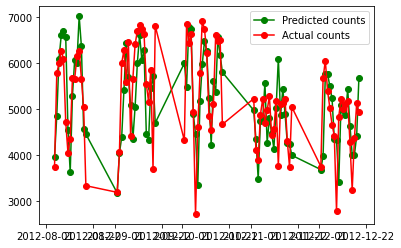

<Figure size 432x288 with 0 Axes>

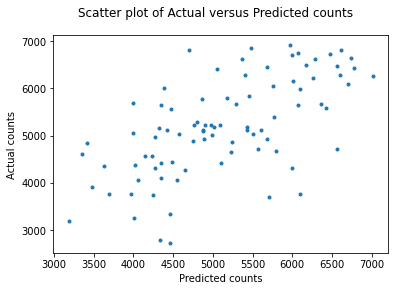

rmse: 844.6393596004416
mae: 648.422772496843
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  345
Model:                            GLM   Df Residuals:                      314
Model Family:                 Poisson   Df Model:                           30
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11279.
Date:                Tue, 06 Oct 2020   Deviance:                       19759.
Time:                        11:51:03   Pearson chi2:                 1.84e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1    

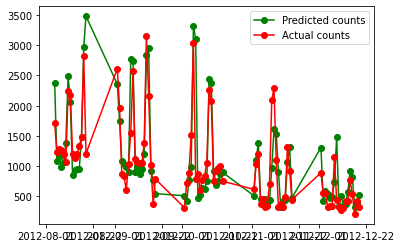

<Figure size 432x288 with 0 Axes>

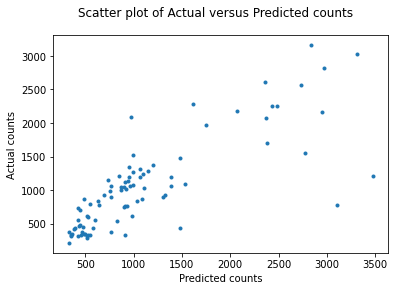

rmse: 481.2550815193083
mae: 294.8721040817543


In [26]:
mus_reg,rmse_reg,mae_reg = train_model(reg_expr,reg_train,reg_test,'registered_sum')
mus_cas,rmse_cas,mae_cas = train_model(cas_expr,cas_train,cas_test,'casual_sum')
mus_reg.index = mus_reg.index.astype('str')
mus_cas.index = mus_cas.index.astype('str')

In [27]:
from scipy.stats import poisson
def get_normed_probs(mu,num=1):
 #Get normalized probabilities from mean+-std of poisson distribution
 mean,std = int(mu[0]),int(np.sqrt(mu[0]))
 dist = poisson(mu=mean)
 probs = [(var,dist.pmf(var)) for var in range(max(mean-num*std,0),mean+num*std)]                                             
 norm_probes = [(prob[0],prob[1]/sum(list(zip(*probs))[1])) for prob in probs]
 return norm_probes

def calc_revenue(current_tup,other_tup):
  # The intuition behind this is to run over all the distributino and calc the rxpecatation for each pair according to the specifications 
  # Where I assume that if I have a free bcycle I would rather give it to casual the registered 8>-4-1
  reg_current,cas_current = current_tup
  reg_other,cas_other = other_tup
  current_sum = reg_current+cas_current
  other_sum = reg_other+cas_other

  if other_sum==current_sum:
    return reg_other*4+cas_other*8
  
  elif current_sum>other_sum:
    return reg_other*4+cas_other*8-10*(current_sum-other_sum)

  else:
     if current_sum<=cas_other:
       return current_sum*8-(cas_other-current_sum)*8-(reg_other)*5
     else:
       return cas_other*8+(current_sum-cas_other)*4-5*(other_sum-current_sum)


for day in range(len(mus_reg)):
  #Get desried number of bikes for each day in test_set
  reg_probs= get_normed_probs(mus_reg.values[day])
  cas_probs= get_normed_probs(mus_cas.values[day])
  sum_dict = {}
  for num,prob in reg_probs:
    for sub_num,sub_prob in cas_probs:
      sum_dict[(num,sub_num)] = prob*sub_prob

  from collections import defaultdict
  tot_dict = defaultdict(int)
  #This code isn't well optimized and should be modified
  for i,(key,value) in enumerate(sum_dict.items()):
    # print (i)
    for sub_key,sub_value in sum_dict.items():
      tot_dict[key]+=(sub_value*calc_revenue(key,sub_key))

  final_dict = defaultdict(list)
  for key,value in sum_dict.items():
    final_dict[sum(key)].append((tot_dict[key],sum_dict[key]))
  
  print ("The number of optimized bike prediction for {} day is:{}".format(mus_reg.iloc[day].name,max(final_dict, key=final_dict.get)))


KeyboardInterrupt: ignored